In [1]:
import os

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


### Load Models and Images

In [2]:
AGE_CLASS = {'(0,2)':0,'(4,6)':1 
             ,'(8,13)':2,'(15,20)':3
             ,'(25,32)':4,'(38,43)':5
             ,'(48,53)':6,'(60,100)':7}

GENDER_CLASS = {'m':0,'f':1}

In [3]:
#load images
X_train, y_train = [], []
X_test, y_test = [], []

for image in os.listdir('train'):
    y_train.append(image.split('_')[1].split('.')[0])
    X_train.append(cv2.imread('train/'+image))

for image in os.listdir('test'):
    y_test.append(image.split('_')[1].split('.')[0])
    X_test.append(cv2.imread('test/'+image))
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [4]:
num_classes = len(AGE_CLASS)
input_shape = (227,227,3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 55, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 128)       73856     
__________

In [11]:
#loading previously trained weights
model.load_weights('age.h5')

In [12]:
AGE_CLASS

{'(0,2)': 0,
 '(4,6)': 1,
 '(8,13)': 2,
 '(15,20)': 3,
 '(25,32)': 4,
 '(38,43)': 5,
 '(48,53)': 6,
 '(60,100)': 7}

In [13]:
def get_conf(prediction):
    #return confidence of underage or adult and return underage:0 or adult:1
    und_conf,ad_conf = np.sum(prediction[0,:3])+prediction[0,3]/2,prediction[0,3]/2+np.sum(prediction[0,4:])
    return max(und_conf,ad_conf),np.argmax([und_conf,ad_conf])

In [209]:
#We now switch back to underage or adult
nb_image = 19
img = X_test[nb_image]
label = np.zeros(len(AGE_CLASS)) ; label[int(y_test[nb_image])] = 1.
prediction = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
conf,adulthod = get_conf(prediction)
print(prediction)
print(conf,adulthod)

[[3.5994210e-05 3.3872655e-07 3.3676621e-11 4.2269107e-06 9.8426974e-01
  1.5676254e-02 8.7601040e-07 1.2567354e-05]]
0.999961582296919 1


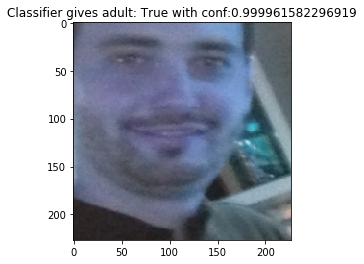

In [210]:
plt.imshow(img)
plt.title('Classifier gives adult: {} with conf:{}'.format(bool(adulthod),conf))
plt.show()

### Create Adversarial

In [154]:
def find_epsilon(img,adv):
    epsilons = np.linspace(-20,20,200)
    conf_s,adulthod_s = get_conf(model.predict(img))
    
    for i, eps in tqdm(enumerate(epsilons)):
        adv_x = img + eps*adv.reshape(1,array.shape[2],array.shape[3],array.shape[4])
        prediction = model.predict(adv_x)
        conf,adulthod = get_conf(prediction)
        if adulthod_s != adulthod: return eps
    return 0

In [155]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [156]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

### Find all possible adversarial images for our dataset

In [161]:
adversarial = []
for nb_img in range(len(X_test)):
    img = X_test[nb_img]
    label = np.zeros(len(AGE_CLASS)) ; label[int(y_test[nb_img])] = 1.
    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    img = img.astype(np.float32)
    tens = tf.convert_to_tensor(img)
    prediction = model(tens)
    loss = loss_object(label,prediction)

    gradient = tf.gradients(loss,tens)
    signed_grad = tf.sign(gradient)
    
    array = signed_grad.eval(session=sess)
    eps = find_epsilon(img,array)
    if eps: adversarial.append((nb_img,eps))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
200it [00:02, 77.90it/s]
0it [00:00, ?it/s]
200it [00:02, 73.96it/s]
200it [00:02, 73.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
136it [00:01, 73.60it/s]
0it [00:00, ?it/s]
200it [00:02, 72.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
200it [00:02, 74.38it/s]
8it [00:00, 43.80it/s]
0it [00:00, ?it/s]
200it [00:02, 76.38it/s]
200it [00:02, 76.24it/s]
200it [00:02, 76.21it/s]
200it [00:02, 75.90it/s]
0it [00:00, ?it/s]
184it [00:02, 74.80it/s]
200it [00:02, 75.71it/s]
200it [00:02, 75.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
200it [00:02, 75.36it/s]
200it [00:02, 75.27it/s]
200it [00:02, 75.13it/s]
0it [00:00, ?it/s]
200it [00:02, 74.33it/s]
200it [00:02, 75.12it/s]
200it [00:02, 74.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
200it [00:02, 74.75it/s]
200it [00:02, 74.35it/s]
200it [00:02, 74.64it/s]
200it [00

In [202]:
#uncomment to get all the epsilons to get adversarial and the working images
#adversarial

In [200]:
#find all people that are less or equal than 20
np.where(y_test.astype(int)<=3)

(array([ 26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  56,  57,
         58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,  70,  71,
         72, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130]),)

### Example 1 adult->child

In [218]:
nb_image = 0
img = X_test[nb_image]
label = np.zeros(len(AGE_CLASS)) ; label[int(y_test[nb_image])] = 1.
img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
img = img.astype(np.float32)
tens = tf.convert_to_tensor(img)
prediction = model(tens)
loss = loss_object(label,prediction)

gradient = tf.gradients(loss,tens)
signed_grad = tf.sign(gradient)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


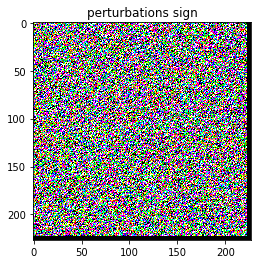

In [219]:
array = signed_grad.eval(session=sess)
plt.imshow(array.reshape(array.shape[2],array.shape[3],array.shape[4]))
plt.title('perturbations sign')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


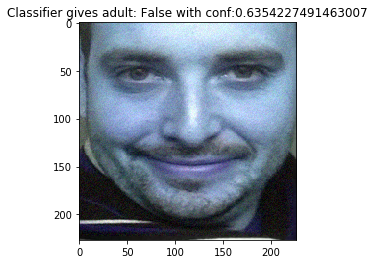

In [220]:
eps = 9

adv_x = img + eps*array.reshape(1,array.shape[2],array.shape[3],array.shape[4])
prediction = model.predict(adv_x)
conf,adulthod = get_conf(prediction)
plt.imshow(adv_x.astype(int).reshape(227,227,3))
plt.title('Classifier gives adult: {} with conf:{}'.format(bool(adulthod),conf))
plt.show()


### Example 2 Child -> Adult

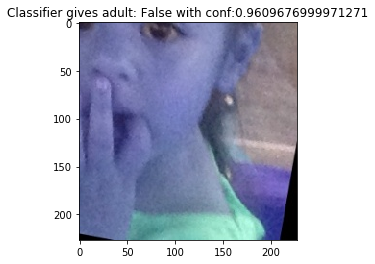

In [215]:
number = 26
img = X_test[number]
prediction = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
label = np.zeros(len(AGE_CLASS)) ; label[int(y_test[number])] = 1.
conf,adulthod = get_conf(prediction)

img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
img = img.astype(np.float32)
tens = tf.convert_to_tensor(img)
prediction = model(tens)
loss = loss_object(label,prediction)

gradient = tf.gradients(loss,tens)
signed_grad = tf.sign(gradient)

plt.imshow(X_test[number])
plt.title('Classifier gives adult: {} with conf:{}'.format(bool(adulthod),conf))
plt.show()

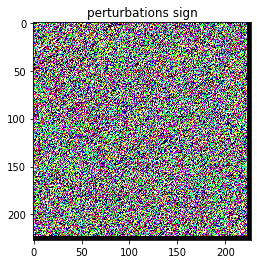

In [216]:
array = signed_grad.eval(session=sess)
show = tf.clip_by_value(array, 0, 1)
plt.imshow(show.eval(session=sess).reshape(array.shape[2],array.shape[3],array.shape[4]))
plt.title('perturbations sign')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


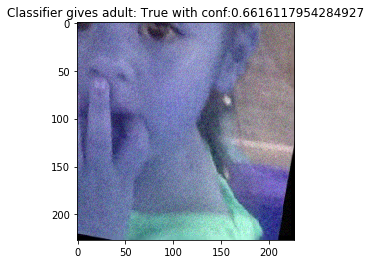

In [199]:
eps = 10

adv_x = img + eps*array.reshape(1,array.shape[2],array.shape[3],array.shape[4])
prediction = model.predict(adv_x)
conf,adulthod = get_conf(prediction)
plt.imshow(adv_x.astype(int).reshape(227,227,3))
plt.title('Classifier gives adult: {} with conf:{}'.format(bool(adulthod),conf))
plt.show()